# Item Scraper

This jupyter notebook file contains the code used for scraping vinyl record data from amazon.ca to be analyzed

In [18]:
# importing libraries
from bs4 import BeautifulSoup
import requests
import time
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv

import smtplib  #for sending emails
import os
from email.message import EmailMessage
import imghdr

# Setting environment variables for email address and password
os.environ["email_user"] = 'mitchbrownuw@gmail.com'
os.environ["user_pass"] = 'yeioupexaylbgggj'

## Create csv to append entries to

In [249]:
def create_csv():
    header = ['Artist', 'Album', "Rating", "Number of Ratings", "Price", "DoubleLP", "Date", 'URL']

    # commented out to not overwite data
    with open('amazon-price-tracker.csv', 'w', newline='', encoding='UTF8') as f:
        writer = csv.writer(f)
        writer.writerow(header)

In [21]:
os.path.exists('out.jpg')

True

## Function to Scrape Data From Each url Provided

In [14]:
def update_price(url):

    # setting up the BeatifulSoup object
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.content, "html.parser")

    # scrape data

    # meta info
    title = soup.find(id = 'productTitle').get_text().strip()
    artist = soup.find('span', class_="author notFaded").find('a', class_='a-link-normal').get_text().strip()
    rating = soup.find('span', class_='a-icon-alt').get_text().strip().split()[0]
    num_ratings = soup.find(id = 'acrCustomerReviewText').get_text().strip().split()[0]
    
    # if price does not exist, fill with "None"
    try:
        price = float(soup.find('span', class_='a-offscreen').get_text().strip()[1:])
    except ValueError:
        return None

    # return the number of LPs. Could compare with price single vs double
    info = soup.find('ul', class_='a-unordered-list a-nostyle a-vertical a-spacing-none detail-bullet-list').get_text().strip().split()
    lp_num = int(info[-1])
    if lp_num == 2:
        doublelp = True
    else:
        doublelp = False

    # scrape date
    today = datetime.date.today()

    link = url

    # set up list of variables to be appeded to existing pandas data.frame
    header = ['Artist', 'Album', "Rating", "Number of Ratings", "Price", "LPs", "Date", 'url']
    data = [artist, title, rating, num_ratings, price, lp_num, today, link]

    with open('webscraping_amazon_vinyl.csv', 'a+', newline='', encoding='UTF8') as f:
        writer = csv.writer(f)
        writer.writerow(data)

## Funciton Send Ourselves an Email

In [15]:

def send_mail(album, type='drop'):
    email_address = os.environ.get('email_user')
    email_password = os.environ.get('user_pass')

    band_name = album.iloc[0,0]
    album_name = album.iloc[0,1]
    item_link = album.iloc[0,-1]

    price_history = sns.relplot(data=album, x='Date', y='Price',
            kind='line').set(
                title='Price History of ' + album_name + ' by ' + band_name
            )
    
    price_history.savefig("price_history.jpg")

    
    msg = EmailMessage()

    if type == "drop":

        old_price = album.iloc[-2,4]
        new_price = album.iloc[-1,4]

        msg['Subject'] = album_name + ' by the ' + band_name + ' has Dropped in Price!'
        msg['From'] = email_address
        msg['To'] = 'mitchbrownuw@gmail.com'
        msg.set_content('A Vinyl Record you were watching has seen a considerable change in price! Now is your time to pick it up!\n\n' + album_name + ' by the ' + band_name + ' has gone from $' + str(old_price) + " to $" + str(new_price) + ' pick it up here: ' +  str(item_link))

    if type == "available":

        new_price = album.iloc[-1,4]

        msg['Subject'] = album_name + ' by the ' + band_name + ' is Available Again'
        msg['From'] = email_address
        msg['To'] = 'mitchbrownuw@gmail.com'
        msg.set_content('A Vinyl Record you were watching has become available again! Now is your time to pick it up!\n\n' + album_name + ' by the ' + band_name + ' is now available at $' + str(new_price) + ' pick it up here: ' +  str(item_link))

    # if we want to attach multiple files
    files = ['price_history.jpg', 'all_item_history.jpg']

    # attaching images to the email containing the price history of the vinyl
    for file in files:
        with open(file, 'rb') as f:
            file_data = f.read()
            file_type = imghdr.what(f.name)     # tells us the file type of the image (useful if printing multiple images)
            file_name = f.name

        # attach images to message
        msg.add_attachment(file_data, maintype='image', subtype=file_type, filename=file_name)

    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
        smtp.login(email_address, email_password)       # log into our mail server

        smtp.send_message(msg)

## Make a Master function to scrape the data and send and email if there is a price change

In [16]:
def update_and_email(items, file_name='amazon-price-tracker.csv'):
    
    # if .csv does no exist, create one to store data
    if os.path.exists(file_name) == False:

        # set column names
        header = ['Artist', 'Album', "Rating", "Number of Ratings", "Price", "DoubleLP", "Date", 'URL']

        # commented out to not overwite data
        with open('amazon-price-tracker.csv', 'w', newline='', encoding='UTF8') as f:
            writer = csv.writer(f)
            writer.writerow(header)
    
    df = pd.read_csv('amazon-price-tracker.csv')

    # loop through dictionary and update csv    
    for value in items.values():
        update_price(value)

    # plot of price history for all watch list items to be attached to email
    all_item_history = sns.relplot(data=df, x='Date', y='Price',
            kind='line',
            hue = 'Album').set(
                title='Price History of Every Watched Item'
            )
    
    all_item_history.savefig("all_item_history.jpg")    # save file as .jpg

    # check the price history of each album to see if there is a drop in price
    for album in df['Album'].unique():
        single_album = df[df['Album'] == album]

        # if there is a price drop, send an email
        if (len(single_album) > 1) and (single_album.iloc[-1,4] != None) and (single_album.iloc[-2,4] != None):
            if ((single_album.iloc[-1,4] - single_album.iloc[-2,4]) < -0.5):
                send_mail(single_album)
        # if there an album becomes available again, send an email
        elif (len(single_album) > 1) and (single_album.iloc[-2,4] == None) and (single_album.iloc[-1,4] != None):
            send_mail(single_album, type='available')

In [22]:
def price_tracker(items, freq='day'):
    df = pd.read_csv('webscraping_amazon_vinyl.csv')

    if freq == 'day':
        time = 864000
    if freq == 'week':
        time = 8640 * 7
    if type(freq) == int:
        time = freq

    while(True):
            update_and_email(items)
            time.sleep(time)

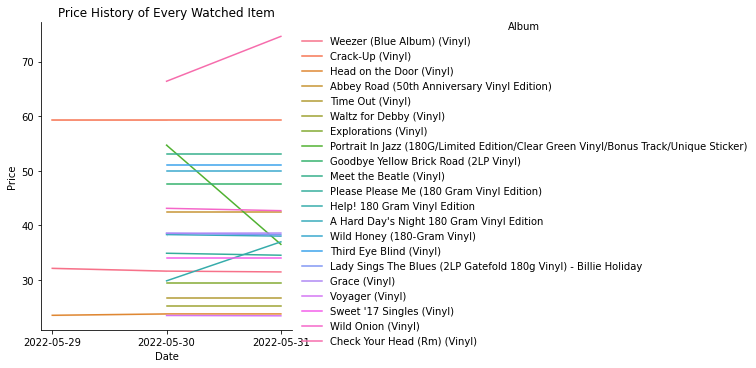

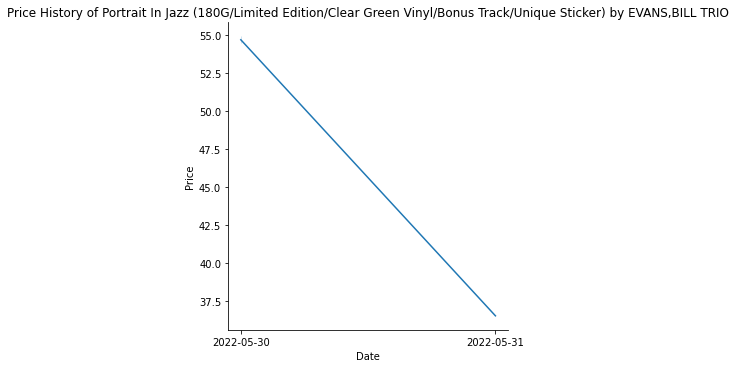

In [19]:
urls = {"Weezer-Blue-Ablum":'https://www.amazon.ca/Weezer-Blue-Album-Vinyl/dp/B01L2ZS87S/ref=asc_df_B01L2ZS87S/?tag=googleshopc0c-20&linkCode=df0&hvadid=292997009494&hvpos=&hvnetw=g&hvrand=17970184648922962140&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=1002283&hvtargid=pla-439544140972&psc=1',
        "Weezer-Pinkerton":'https://www.amazon.ca/Pinkerton-Vinyl-Weezer/dp/B01L2ZS882/ref=sr_1_1?crid=22OIHD8RFNDCH&keywords=weezer+pinkerton&qid=1653680516&s=music&sprefix=weezer+pinkerton%2Cpopular%2C84&sr=1-1',
        "Fleet-Foxes-Crack-Up":'https://www.amazon.ca/Crack-Up-Vinyl-Fleet-Foxes/dp/B06XGN3ZD5/ref=sr_1_5?crid=3FHPTOIY9OSAK&keywords=fleet+foxes+helplessness+blues+vinyl&qid=1653680596&s=music&sprefix=fleet+foxes+helplessness+blues+vinyl%2Cpopular%2C88&sr=1-5',
        "The Cure-Head on the Door":'https://www.amazon.ca/Head-Door-Vinyl-Cure/dp/B000091EQO/ref=sr_1_3?crid=TN45MHTNELRL&keywords=the+cure+vinyl&qid=1653680657&s=music&sprefix=the+cure+vinyl%2Cpopular%2C79&sr=1-3',
        "The Beatles-Abbey Road":'https://www.amazon.ca/Abbey-Road-50th-Anniversary-Vinyl/dp/B07VNS48HD/ref=sxin_14_ac_d_rm?ac_md=3-3-ZGlzcXVlIHZpbnlsZQ%3D%3D-ac_d_rm_rm_rm&content-id=amzn1.sym.72e1e133-b969-4a44-ad15-4bedb4de079e%3Aamzn1.sym.72e1e133-b969-4a44-ad15-4bedb4de079e&crid=288IH9R0J79O3&cv_ct_cx=vinyl+music&keywords=vinyl+music&pd_rd_i=B07VNS48HD&pd_rd_r=46acda06-729f-4645-9bee-3bd1682c9757&pd_rd_w=sLXcM&pd_rd_wg=H1z9X&pf_rd_p=72e1e133-b969-4a44-ad15-4bedb4de079e&pf_rd_r=DJGFCX009TWQS5T12MAT&psc=1&qid=1653922198&sprefix=vinyl+music%2Caps%2C87&sr=1-4-7d9bfb42-6e38-4445-b604-42cab39e191b',
        "Dave Brubeck-Time Out":'https://www.amazon.ca/Time-Vinyl-Dave-Quartet-Brubeck/dp/B0034JV5Y4/ref=sr_1_1?crid=2KFHF31Q9ZNLM&keywords=dave+brubeck+vinyl&qid=1653922267&sprefix=dave+brubeck+vinyl%2Caps%2C82&sr=8-1',
        "Bill Evans-Waltz for Debby":'https://www.amazon.ca/Waltz-Debby-Vinyl-Bill-Evans/dp/B006PF212E/ref=sr_1_5?crid=33TPQZPKSEHE7&keywords=bill+evans+vinyl&qid=1653922323&sprefix=bill+evans%2Caps%2C80&sr=8-5',
        "Bill Evans-Explorations":'https://www.amazon.ca/Explorations-Vinyl-Bill-Evans/dp/B006YTLMIK/ref=sr_1_8?crid=33TPQZPKSEHE7&keywords=bill+evans+vinyl&qid=1653922365&sprefix=bill+evans%2Caps%2C80&sr=8-8',
        "Bill Evans-Portrait In Jazz":'https://www.amazon.ca/Portrait-Jazz-Vinyl-Bill-Evans/dp/B078XX3MMV/ref=sr_1_22?crid=33TPQZPKSEHE7&keywords=bill+evans+vinyl&qid=1653922365&sprefix=bill+evans%2Caps%2C80&sr=8-22',
        "Elton John-Goodbye Yellow Brick Road":'https://www.amazon.ca/Goodbye-Yellow-Brick-Road-Vinyl/dp/B00I480SAC/ref=sr_1_5?crid=PMGSC3J86ZR&keywords=elton+john+vinyl&qid=1653922448&sprefix=elton+john+vinyl%2Caps%2C80&sr=8-5',
        "The Beatles-Meet the Beatles":'https://www.amazon.ca/Meet-Beatle-Vinyl-Beatles/dp/B00008EUK8/ref=sr_1_8?crid=2VL7HJJXRJDFY&keywords=beatles+vinyl&qid=1653922501&sprefix=beatles+vinyl%2Caps%2C100&sr=8-8',
        "The Beatles-Please Please Me":'https://www.amazon.ca/Please-Me-180-Gram-Vinyl/dp/B0041KVX1K/ref=sr_1_11?crid=2VL7HJJXRJDFY&keywords=beatles+vinyl&qid=1653922537&sprefix=beatles+vinyl%2Caps%2C100&sr=8-11',
        "The Beatles-Help":'https://www.amazon.ca/Help-180-Gram-Vinyl-Beatles/dp/B0041KVV8A/ref=sr_1_17?crid=2VL7HJJXRJDFY&keywords=beatles+vinyl&qid=1653922537&sprefix=beatles+vinyl%2Caps%2C100&sr=8-17',
        "The Beatles-A Hard Day's Night":'https://www.amazon.ca/Hard-Days-Night-Gram-Vinyl/dp/B0041KVX1A/ref=sr_1_47?crid=2VL7HJJXRJDFY&keywords=beatles+vinyl&qid=1653922537&sprefix=beatles+vinyl%2Caps%2C100&sr=8-47',
        "The Beach Boys-Wild Honey":'https://www.amazon.ca/Wild-Honey-180-Gram-Vinyl-Beach/dp/B071KTB9JH/ref=sr_1_30?crid=3BQVMBASTAVL8&keywords=beach+boys+vinyl&qid=1653922670&sprefix=beach+boys+vinyl%2Caps%2C83&sr=8-30',
        "Third Eye Blind-Third Eye Blind":'https://www.amazon.ca/Third-Eye-Blind-Vinyl/dp/B09ZYRBFMG/ref=sr_1_1?keywords=third+eye+blind+vinyl&qid=1653922733&sprefix=third+eye%2Caps%2C96&sr=8-1',
        "Billie Holiday-Lady Sings The Blues":'https://www.amazon.ca/Lady-Sings-Blues-Gatefold-Vinyl/dp/B00ETHPH8A/ref=sr_1_1?crid=1DD39UTWT090K&keywords=billie+holiday+vinyl&qid=1653922801&sprefix=billie+holiday+vinyl%2Caps%2C92&sr=8-1',
        "Jeff Buckly-Grace":'https://www.amazon.ca/Grace-Vinyl-Jeff-Buckley/dp/B00447G2NY/ref=sr_1_1?crid=15B4TUVPUDRN1&keywords=jeff+buckley+vinyl&qid=1653923430&sprefix=jeff+buckley+vinyl%2Caps%2C84&sr=8-1',
        "Current Joys-Voyager":'https://www.amazon.ca/Voyager-Vinyl-Current-Joys/dp/B08YL9DFBG/ref=sr_1_1?crid=2I5B31W93N9MS&keywords=current+joys+vinyl&qid=1653923504&sprefix=current+joys+vinyl%2Caps%2C81&sr=8-1',
        "Current Joys-Different Age":'https://www.amazon.ca/Different-Age-Vinyl-Current-Joys/dp/B0794Y8FN7/ref=sr_1_2?crid=2I5B31W93N9MS&keywords=current+joys+vinyl&qid=1653923534&sprefix=current+joys+vinyl%2Caps%2C81&sr=8-2',
        "Twin Peaks-Singles":'https://www.amazon.ca/Sweet-Singles-Vinyl-Twin-Peaks/dp/B077XWZSBB/ref=sr_1_10?crid=V9SQO06FUSSE&keywords=twin+peaks+vinyl&qid=1653923596&sprefix=twin+peaks+vinyl%2Caps%2C86&sr=8-10',
        "Twin Peaks-Wild Onion":'https://www.amazon.ca/Wild-Onion-Vinyl-Twin-Peaks/dp/B00LBU7LVO/ref=sr_1_12?crid=V9SQO06FUSSE&keywords=twin+peaks+vinyl&qid=1653923628&sprefix=twin+peaks+vinyl%2Caps%2C86&sr=8-12',
        "Beastie Boys-Check Your Head":'https://www.amazon.ca/Check-Your-Head-Rm-Vinyl/dp/B001Q8FSQG/ref=sr_1_1?crid=9SY5FZLED0YK&keywords=the+beastie+boys+vinyl&qid=1653923678&sprefix=the+beastie+boys+vinyl%2Caps%2C101&sr=8-1'
}

df = pd.read_csv('webscraping_amazon_vinyl.csv')
price_tracker(urls, df)
# while(True):
#         price_tracker(urls, df)
#         time.sleep(86400)

Code for README.txt snapshot

In [11]:
test = {"The Beatles-Please Please Me":'https://www.amazon.ca/Please-Me-180-Gram-Vinyl/dp/B0041KVX1K/ref=sr_1_11?crid=2VL7HJJXRJDFY&keywords=beatles+vinyl&qid=1653922537&sprefix=beatles+vinyl%2Caps%2C100&sr=8-11'}

In [ ]:
def price_tracker_test(test, df):
    for value in test.values():
        update_price(value)

    all_item_history = sns.relplot(data=df, x='Date', y='Price',
            kind='line',
            hue = 'Album').set(
                title='Price History of Every Watched Item'
            )
    
    all_item_history.savefig("all_item_history.jpg")

    for album in df['Album'].unique():
        single_album = df[df['Album'] == album]

        if (len(single_album) > 1) and (single_album.iloc[-1,4] != None) and (single_album.iloc[-2,4] != None):
            if (single_album.iloc[-1,4] == single_album.iloc[-2,4]):
                send_mail(single_album)

In [ ]:
def send_mail_test(album, type='drop'):
    email_address = os.environ.get('email_user')
    email_password = os.environ.get('user_pass')

    band_name = album.iloc[0,0]
    album_name = album.iloc[0,1]
    item_link = album.iloc[0,-1]

    price_history = sns.relplot(data=album, x='Date', y='Price',
            kind='line').set(
                title='Price History of ' + album_name + ' by ' + band_name
            )
    
    price_history.savefig("price_history.jpg")

    
    msg = EmailMessage()

    if type == "drop":

        old_price = album.iloc[-2,4]
        new_price = album.iloc[-1,4]

        msg['Subject'] = album_name + ' by the ' + band_name + ' has Dropped in Price!'
        msg['From'] = email_address
        msg['To'] = 'mitchbrownuw@gmail.com'
        msg.set_content('A Vinyl Record you were watching has seen a considerable change in price! Now is your time to pick it up!\n\n' + album_name + ' by the ' + band_name + ' has gone from $' + str(old_price) + " to $" + str(new_price) + ' pick it up here: ' +  str(item_link))

    if type == "available":

        new_price = album.iloc[-1,4]

        msg['Subject'] = album_name + ' by the ' + band_name + ' is Available Again'
        msg['From'] = email_address
        msg['To'] = 'mitchbrownuw@gmail.com'
        msg.set_content('A Vinyl Record you were watching has become available again! Now is your time to pick it up!\n\n' + album_name + ' by the ' + band_name + ' is now available at $' + str(new_price) + ' pick it up here: ' +  str(item_link))

    # if we want to attach multiple files
    files = ['price_history.jpg', 'all_item_history.jpg']

    # attaching images to the email containing the price history of the vinyl
    for file in files:
        with open(file, 'rb') as f:
            file_data = f.read()
            file_type = imghdr.what(f.name)     # tells us the file type of the image (useful if printing multiple images)
            file_name = f.name

        # attach images to message
        msg.add_attachment(file_data, maintype='image', subtype=file_type, filename=file_name)

    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
        smtp.login(email_address, email_password)       # log into our mail server

        smtp.send_message(msg)

In [12]:

df

NameError: name 'df' is not defined